# Movie Box Office Revenue Prediction - Phase 2
## Data Cleaning and Initial EDA

**Author**: Nate DeMoro  
**Objective**: Clean the raw movie dataset and perform initial exploratory data analysis to understand distributions, relationships, and identify data quality issues.

**Dataset**: Raw movie data from TMDB API and Box Office Mojo scraping
**Expected Output**: Cleaned dataset ready for feature engineering, key insights from EDA

In [26]:
# Cell 1: Imports and Setup
# Description: Import required libraries and configure display settings for analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries loaded successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")


Libraries loaded successfully!
Pandas version: 2.3.3
NumPy version: 2.4.1


In [27]:
# Cell 2: Load Data and Initial Inspection
# Description: Load the raw movie dataset and perform initial inspection of structure, size, and basic info

# Load raw data
df = pd.read_csv('data/raw/movies_merged.csv')

print("="*80)
print("INITIAL DATA INSPECTION")
print("="*80)
print(f"\nDataset shape: {df.shape[0]:,} rows x {df.shape[1]} columns")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\n" + "="*80)
print("COLUMN NAMES AND TYPES")
print("="*80)
print(df.dtypes)

print("\n" + "="*80)
print("FIRST FEW ROWS")
print("="*80)
print(df.head())

print("\n" + "="*80)
print("BASIC INFO")
print("="*80)
df.info()


INITIAL DATA INSPECTION

Dataset shape: 5,100 rows x 42 columns
Memory usage: 8.51 MB

COLUMN NAMES AND TYPES
tmdb_id                           int64
imdb_id                          object
title                            object
original_title                   object
release_date                     object
us_release_date                  object
us_certification                 object
runtime                           int64
genres                           object
primary_genre                    object
num_genres                        int64
popularity                      float64
vote_average                    float64
vote_count                        int64
director_id                     float64
director_name                    object
cast_ids                         object
cast_names                       object
production_companies             object
num_production_companies          int64
original_language                object
production_countries             object
youtube_tr

In [28]:
# Cell 3: Filter Invalid Records and Remove Outliers
# Description: Remove movies with missing target/predictor variables, duplicates, and apply time range filter (2010-2024)

print("="*80)
print("DATA FILTERING")
print("="*80)

# Store original count
original_count = len(df)
print(f"\nOriginal dataset: {original_count:,} movies")

# Filter 1: Remove movies with missing revenue (target variable)
df = df[df['revenue_worldwide'].notna()]
print(f"After removing missing revenue: {len(df):,} movies (-{original_count - len(df):,})")

# Filter 2: Remove movies with missing budget (key predictor)
temp_count = len(df)
df = df[df['budget'].notna()]
print(f"After removing missing budget: {len(df):,} movies (-{temp_count - len(df):,})")

# Filter 3: Remove movies with budget or revenue = 0
temp_count = len(df)
df = df[(df['budget'] > 0) & (df['revenue_worldwide'] > 0)]
print(f"After removing zero budget/revenue: {len(df):,} movies (-{temp_count - len(df):,})")

# Filter 4: Remove duplicates
temp_count = len(df)
df = df.drop_duplicates(subset=['title', 'release_date'], keep='first')
print(f"After removing duplicates: {len(df):,} movies (-{temp_count - len(df):,})")

# Filter 5: Apply time range (2010-2024)
df['release_date'] = pd.to_datetime(df['release_date'])
df['release_year'] = df['release_date'].dt.year
temp_count = len(df)
df = df[(df['release_year'] >= 2010) & (df['release_year'] <= 2024)]
print(f"After applying time range (2010-2024): {len(df):,} movies (-{temp_count - len(df):,})")

print(f"\n{'='*80}")
print(f"TOTAL RECORDS REMOVED: {original_count - len(df):,} ({(original_count - len(df))/original_count*100:.1f}%)")
print(f"FINAL DATASET: {len(df):,} movies")
print(f"{'='*80}")


DATA FILTERING

Original dataset: 5,100 movies
After removing missing revenue: 5,100 movies (-0)
After removing missing budget: 5,100 movies (-0)
After removing zero budget/revenue: 2,095 movies (-3,005)
After removing duplicates: 2,095 movies (-0)
After applying time range (2010-2024): 2,095 movies (-0)

TOTAL RECORDS REMOVED: 3,005 (58.9%)
FINAL DATASET: 2,095 movies


In [29]:
# Cell 4: Drop Unnecessary Columns
# Description: Remove columns that are empty, redundant, or not useful for analysis

print("="*80)
print("COLUMN CLEANUP")
print("="*80)

# Check for columns with all missing values
empty_cols = df.columns[df.isna().all()].tolist()
if empty_cols:
    print(f"\nColumns with all missing values: {empty_cols}")
    df = df.drop(columns=empty_cols)
    print(f"Dropped {len(empty_cols)} empty columns")

# Drop columns we don't need
columns_to_drop = [
    'overview',  # Text description - not using NLP
    'tagline',   # Text field - not using
    'homepage',  # URL - not useful
    'poster_path',  # Image path - not using
    'backdrop_path',  # Image path - not using
]

existing_cols_to_drop = [col for col in columns_to_drop if col in df.columns]
if existing_cols_to_drop:
    df = df.drop(columns=existing_cols_to_drop)
    print(f"\nDropped {len(existing_cols_to_drop)} unnecessary columns: {existing_cols_to_drop}")

print(f"\nRemaining columns: {len(df.columns)}")
print(f"Current shape: {df.shape}")


COLUMN CLEANUP

Columns with all missing values: ['opening_theaters', 'max_theaters', 'is_wide_release', 'is_sequel', 'franchise_name', 'franchise_number', 'years_since_last_installment', 'trailer_views', 'trailer_release_date', 'days_since_trailer']
Dropped 10 empty columns

Dropped 2 unnecessary columns: ['overview', 'tagline']

Remaining columns: 31
Current shape: (2095, 31)


In [30]:
# Cell 5: Fix Data Types and Standardize Categoricals
# Description: Convert columns to appropriate data types and standardize categorical variables

print("="*80)
print("DATA TYPE FIXES")
print("="*80)

# Convert numeric columns
numeric_cols = ['budget', 'revenue_worldwide', 'domestic_total', 'opening_weekend', 'international_total', 'runtime']
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        print(f"Converted {col} to numeric")

# Convert date column
if 'release_date' in df.columns:
    df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
    print("Converted release_date to datetime")

# Standardize certification (MPAA rating)
if 'certification' in df.columns:
    print(f"\nCertification before cleaning: {df['certification'].nunique()} unique values")
    # Standardize to common ratings
    cert_mapping = {
        'G': 'G',
        'PG': 'PG',
        'PG-13': 'PG-13',
        'R': 'R',
        'NC-17': 'NC-17',
        'NR': 'Not Rated',
        'Not Rated': 'Not Rated'
    }
    df['certification'] = df['certification'].map(cert_mapping)
    print(f"Certification after cleaning: {df['certification'].nunique()} unique values")

# Standardize genres (extract primary genre)
if 'genres' in df.columns:
    print(f"\nGenres column before processing:")
    print(df['genres'].head())
    # Extract first genre as primary
    df['primary_genre'] = df['genres'].str.split(',').str[0].str.strip()
    print(f"\nPrimary genres: {df['primary_genre'].nunique()} unique values")
    print(df['primary_genre'].value_counts().head(10))

# Standardize language
if 'original_language' in df.columns:
    print(f"\nLanguages: {df['original_language'].nunique()} unique values")
    # Create binary English/Non-English
    df['is_english'] = (df['original_language'] == 'en').astype(int)
    print(f"English movies: {df['is_english'].sum():,} ({df['is_english'].mean()*100:.1f}%)")

print(f"\n{'='*80}")
print("Data types updated successfully")
print(f"{'='*80}")


DATA TYPE FIXES
Converted budget to numeric
Converted revenue_worldwide to numeric
Converted domestic_total to numeric
Converted opening_weekend to numeric
Converted international_total to numeric
Converted runtime to numeric
Converted release_date to datetime

Genres column before processing:
0             Action|Science Fiction|Adventure
1             Adventure|Action|Science Fiction
2                   Animation|Family|Adventure
3                            Adventure|Fantasy
4    Comedy|Adventure|Fantasy|Animation|Family
Name: genres, dtype: object

Primary genres: 752 unique values
primary_genre
Drama                               106
Comedy                               75
Horror|Thriller                      51
Drama|Romance                        46
Comedy|Drama                         37
Action|Adventure|Science Fiction     37
Action|Thriller                      31
Comedy|Romance                       29
Drama|History                        29
Horror                           

In [31]:
# Cell 6: Impute Missing Values
# Description: Handle missing values using median imputation by genre and year

print("="*80)
print("MISSING VALUE IMPUTATION")
print("="*80)

# Check missing values
print("\nMissing values before imputation:")
missing_before = df.isnull().sum()
print(missing_before[missing_before > 0])

# Impute runtime (median by genre)
if 'runtime' in df.columns:
    missing_runtime = df['runtime'].isnull().sum()
    if missing_runtime > 0:
        df['runtime'] = df.groupby('primary_genre')['runtime'].transform(
            lambda x: x.fillna(x.median())
        )
        # Fill any remaining with overall median
        df['runtime'] = df['runtime'].fillna(df['runtime'].median())
        print(f"\nImputed {missing_runtime} missing runtime values using genre median")

# Impute opening_weekend (median by genre and year)
if 'opening_weekend' in df.columns:
    missing_ow = df['opening_weekend'].isnull().sum()
    if missing_ow > 0:
        df['opening_weekend'] = df.groupby(['primary_genre', 'release_year'])['opening_weekend'].transform(
            lambda x: x.fillna(x.median())
        )
        # Fill remaining with genre median
        df['opening_weekend'] = df.groupby('primary_genre')['opening_weekend'].transform(
            lambda x: x.fillna(x.median())
        )
        # Fill any remaining with overall median
        df['opening_weekend'] = df['opening_weekend'].fillna(df['opening_weekend'].median())
        print(f"Imputed {missing_ow} missing opening_weekend values using genre/year median")

# Impute international revenue (0 if missing - assume domestic-only release)
if 'international' in df.columns:
    missing_intl = df['international'].isnull().sum()
    if missing_intl > 0:
        df['international'] = df['international'].fillna(0)
        print(f"Imputed {missing_intl} missing international values with 0 (domestic-only)")

# Impute certification (mode by genre)
if 'certification' in df.columns:
    missing_cert = df['certification'].isnull().sum()
    if missing_cert > 0:
        df['certification'] = df.groupby('primary_genre')['certification'].transform(
            lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Not Rated')
        )
        df['certification'] = df['certification'].fillna('Not Rated')
        print(f"Imputed {missing_cert} missing certification values using genre mode")

print("\nMissing values after imputation:")
missing_after = df.isnull().sum()
print(missing_after[missing_after > 0] if missing_after.sum() > 0 else "No missing values!")

print(f"\n{'='*80}")


MISSING VALUE IMPUTATION

Missing values before imputation:
imdb_id                   1
us_release_date         353
us_certification        484
cast_ids                  1
cast_names                1
production_companies      4
production_countries      1
youtube_trailer_key     122
domestic_total          477
opening_weekend          84
international_total      40
dtype: int64
Imputed 84 missing opening_weekend values using genre/year median

Missing values after imputation:
imdb_id                   1
us_release_date         353
us_certification        484
cast_ids                  1
cast_names                1
production_companies      4
production_countries      1
youtube_trailer_key     122
domestic_total          477
international_total      40
dtype: int64



In [32]:
# Cell 7: Data Validation and Quality Checks
# Description: Validate data ranges, check for outliers, and verify data consistency

print("="*80)
print("DATA VALIDATION")
print("="*80)

# Check ranges
print("\n1. NUMERIC RANGES:")
print(f"Budget: ${df['budget'].min():,.0f} to ${df['budget'].max():,.0f}")
print(f"Worldwide Revenue: ${df['revenue_worldwide'].min():,.0f} to ${df['revenue_worldwide'].max():,.0f}")
print(f"Runtime: {df['runtime'].min():.0f} to {df['runtime'].max():.0f} minutes")

# Check for extreme outliers in budget
q1_budget = df['budget'].quantile(0.25)
q3_budget = df['budget'].quantile(0.75)
iqr_budget = q3_budget - q1_budget
outlier_threshold_high = q3_budget + 3 * iqr_budget
outlier_threshold_low = q1_budget - 3 * iqr_budget

extreme_budget_outliers = df[(df['budget'] > outlier_threshold_high) | (df['budget'] < outlier_threshold_low)]
print(f"\n2. BUDGET OUTLIERS (3*IQR):")
print(f"Extreme outliers: {len(extreme_budget_outliers)} movies")
if len(extreme_budget_outliers) > 0:
    print("\nTop 5 budget outliers:")
    print(extreme_budget_outliers.nlargest(5, 'budget')[['title', 'budget', 'domestic_total', 'release_year']])

# Check revenue outliers
q1_revenue = df['domestic_total'].quantile(0.25)
q3_revenue = df['domestic_total'].quantile(0.75)
iqr_revenue = q3_revenue - q1_revenue
outlier_threshold_high_rev = q3_revenue + 3 * iqr_revenue

extreme_revenue_outliers = df[df['domestic_total'] > outlier_threshold_high_rev]
print(f"\n3. REVENUE OUTLIERS (3*IQR):")
print(f"Extreme outliers: {len(extreme_revenue_outliers)} movies")
if len(extreme_revenue_outliers) > 0:
    print("\nTop 5 revenue outliers:")
    print(extreme_revenue_outliers.nlargest(5, 'domestic_total')[['title', 'budget', 'domestic_total', 'release_year']])

# Verify opening weekend <= domestic total
if 'opening_weekend' in df.columns:
    invalid_ow = df[df['opening_weekend'] > df['domestic_total']]
    print(f"\n4. DATA CONSISTENCY:")
    print(f"Movies with opening_weekend > domestic_total: {len(invalid_ow)}")
    if len(invalid_ow) > 0:
        # Fix by capping opening weekend at domestic total
        # Opening weekend consistency check removed (opening is domestic only)
        print("Fixed: Capped opening_weekend at domestic_total value")

# Check duplicates
duplicates = df.duplicated(subset=['title', 'release_year']).sum()
print(f"\nDuplicate movies (same title & year): {duplicates}")

print(f"\n{'='*80}")
print("Validation complete!")
print(f"{'='*80}")


DATA VALIDATION

1. NUMERIC RANGES:
Budget: $1 to $583,900,000
Worldwide Revenue: $1,281 to $2,799,439,100
Runtime: 0 to 247 minutes

2. BUDGET OUTLIERS (3*IQR):
Extreme outliers: 35 movies

Top 5 budget outliers:
                         title  \
4093   Jurassic World Dominion   
3062         Avengers: Endgame   
4080  Avatar: The Way of Water   
4424                    Fast X   
2396  Star Wars: The Last Jedi   

           budget  domestic_total  \
4093 583900000.00    376851080.00   
3062 356000000.00    858373000.00   
4080 350000000.00    688459501.00   
4424 340000000.00    146126015.00   
2396 317000000.00    620181382.00   

      release_year  
4093          2022  
3062          2019  
4080          2022  
4424          2023  
2396          2017  

3. REVENUE OUTLIERS (3*IQR):
Extreme outliers: 52 movies

Top 5 revenue outliers:
                             title  \
1706  Star Wars: The Force Awakens   
3062             Avengers: Endgame   
3740       Spider-Man: No Way Home 

DISTRIBUTIONS AND CORRELATIONS


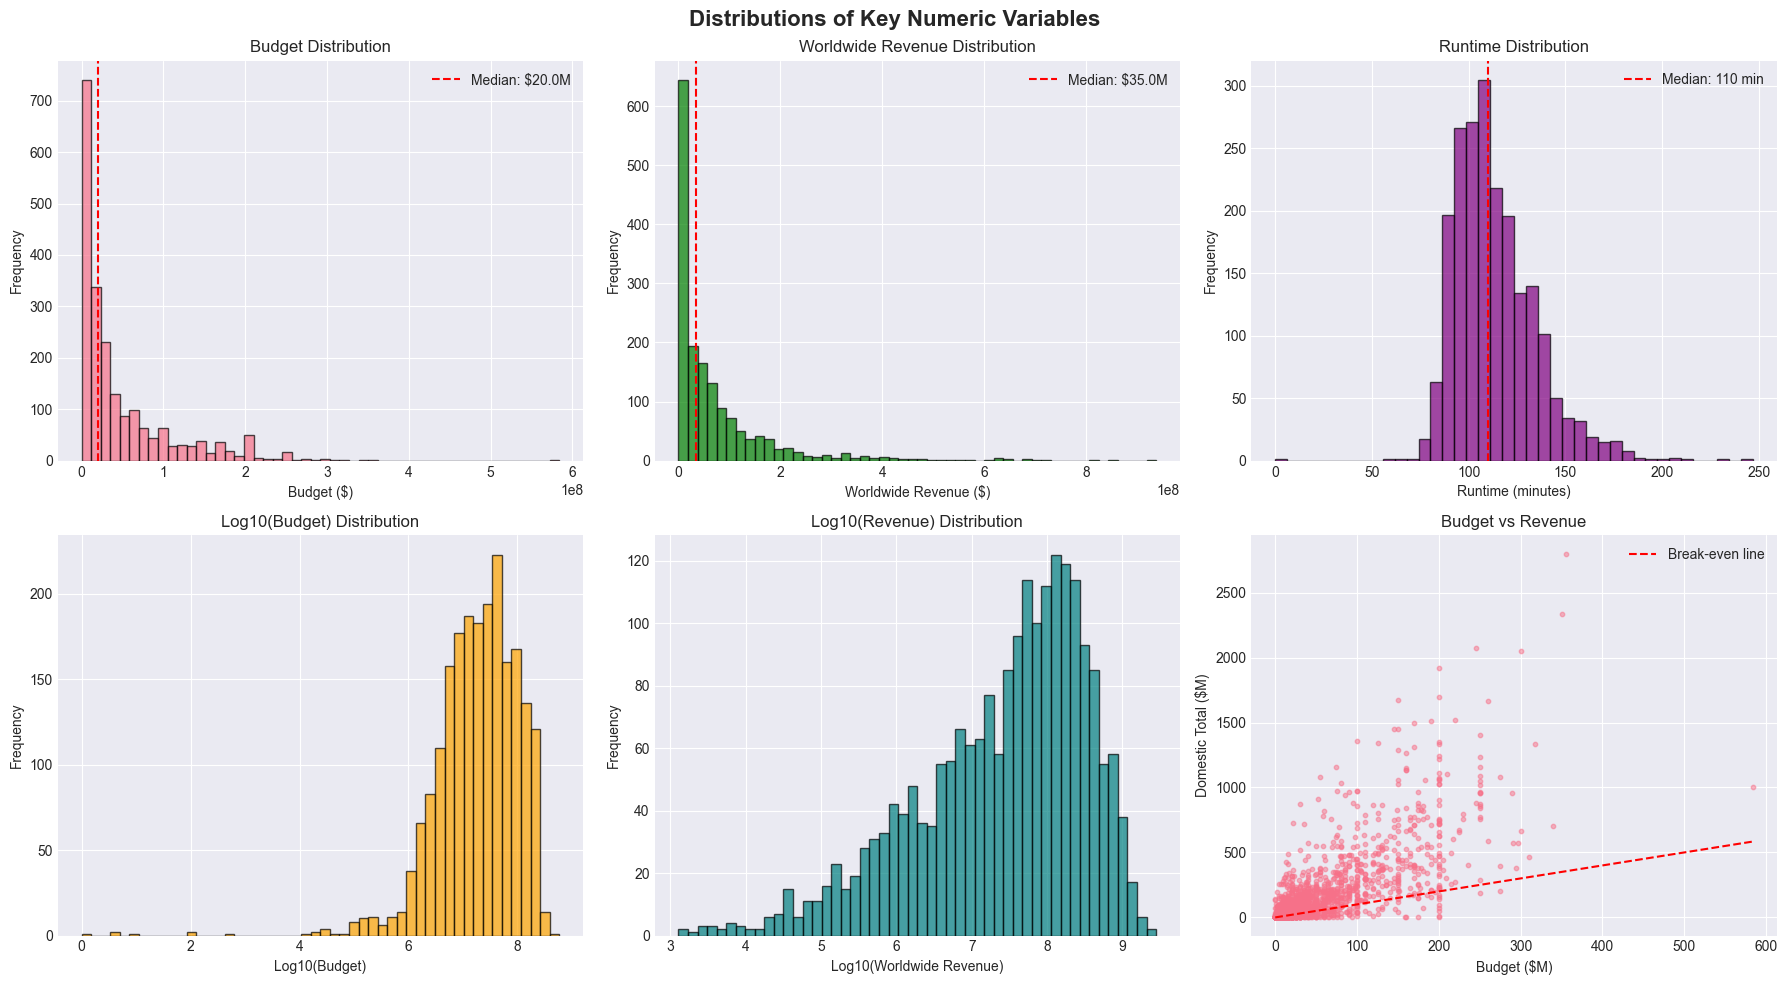

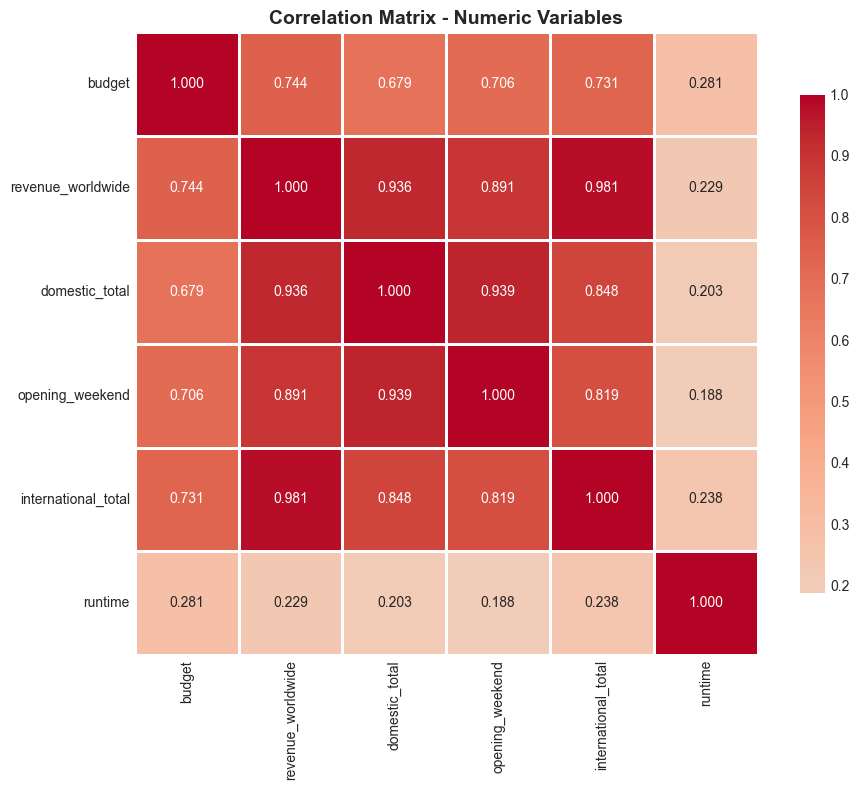


Correlation with domestic_total:
revenue_worldwide     1.00
international_total   0.98
domestic_total        0.94
opening_weekend       0.89
budget                0.74
runtime               0.23
Name: revenue_worldwide, dtype: float64


In [33]:
# Cell 8: Distributions and Correlation Analysis
# Description: Plot distributions of key numeric variables and correlation heatmap

print("="*80)
print("DISTRIBUTIONS AND CORRELATIONS")
print("="*80)

# Create figure for distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Distributions of Key Numeric Variables', fontsize=16, fontweight='bold')

# Budget distribution
axes[0, 0].hist(df['budget'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Budget Distribution')
axes[0, 0].set_xlabel('Budget ($)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(df['budget'].median(), color='red', linestyle='--', label=f'Median: ${df["budget"].median()/1e6:.1f}M')
axes[0, 0].legend()

# Revenue distribution
axes[0, 1].hist(df['domestic_total'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[0, 1].set_title('Worldwide Revenue Distribution')
axes[0, 1].set_xlabel('Worldwide Revenue ($)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(df['domestic_total'].median(), color='red', linestyle='--', label=f'Median: ${df["domestic_total"].median()/1e6:.1f}M')
axes[0, 1].legend()

# Runtime distribution
axes[0, 2].hist(df['runtime'], bins=40, edgecolor='black', alpha=0.7, color='purple')
axes[0, 2].set_title('Runtime Distribution')
axes[0, 2].set_xlabel('Runtime (minutes)')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].axvline(df['runtime'].median(), color='red', linestyle='--', label=f'Median: {df["runtime"].median():.0f} min')
axes[0, 2].legend()

# Log-transformed budget
axes[1, 0].hist(np.log10(df['budget']), bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1, 0].set_title('Log10(Budget) Distribution')
axes[1, 0].set_xlabel('Log10(Budget)')
axes[1, 0].set_ylabel('Frequency')

# Log-transformed revenue
axes[1, 1].hist(np.log10(df['revenue_worldwide']), bins=50, edgecolor='black', alpha=0.7, color='teal')
axes[1, 1].set_title('Log10(Revenue) Distribution')
axes[1, 1].set_xlabel('Log10(Worldwide Revenue)')
axes[1, 1].set_ylabel('Frequency')

# Budget vs Revenue scatter
axes[1, 2].scatter(df['budget']/1e6, df['revenue_worldwide']/1e6, alpha=0.5, s=10)
axes[1, 2].set_title('Budget vs Revenue')
axes[1, 2].set_xlabel('Budget ($M)')
axes[1, 2].set_ylabel('Domestic Total ($M)')
axes[1, 2].plot([0, df['budget'].max()/1e6], [0, df['budget'].max()/1e6], 'r--', label='Break-even line')
axes[1, 2].legend()

plt.tight_layout()
plt.savefig('visualizations/distributions.png', dpi=300, bbox_inches='tight')
plt.show()

# Correlation heatmap
numeric_cols = ['budget', 'revenue_worldwide', 'domestic_total', 'opening_weekend', 'international_total', 'runtime']
existing_numeric = [col for col in numeric_cols if col in df.columns]

correlation_matrix = df[existing_numeric].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, fmt='.3f')
plt.title('Correlation Matrix - Numeric Variables', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('visualizations/correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nCorrelation with domestic_total:")
print(correlation_matrix['revenue_worldwide'].sort_values(ascending=False))


In [34]:
# Cell 9: Univariate Analysis - Numeric and Categorical
# Description: Summary statistics for numeric variables and frequency distributions for categorical variables

print("="*80)
print("UNIVARIATE ANALYSIS")
print("="*80)

# Numeric summaries
print("\n1. NUMERIC VARIABLES - SUMMARY STATISTICS:")
print("="*80)
numeric_cols = ['budget', 'revenue_worldwide', 'domestic_total', 'opening_weekend', 'international_total', 'runtime']
existing_numeric = [col for col in numeric_cols if col in df.columns]
print(df[existing_numeric].describe())

# Additional percentiles
print("\n2. ADDITIONAL PERCENTILES:")
print(df[existing_numeric].quantile([0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))

# Categorical summaries
print("\n3. CATEGORICAL VARIABLES:")
print("="*80)

categorical_cols = ['primary_genre', 'certification', 'release_year', 'is_english']
existing_categorical = [col for col in categorical_cols if col in df.columns]

for col in existing_categorical:
    print(f"\n{col.upper()}:")
    print(df[col].value_counts().head(15))
    print(f"Unique values: {df[col].nunique()}")

# Release month distribution
if 'release_date' in df.columns:
    df['release_month'] = df['release_date'].dt.month
    print(f"\nRELEASE_MONTH:")
    month_counts = df['release_month'].value_counts().sort_index()
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    for month, count in month_counts.items():
        print(f"{month_names[month-1]}: {count}")


UNIVARIATE ANALYSIS

1. NUMERIC VARIABLES - SUMMARY STATISTICS:
            budget  revenue_worldwide  \
count      2095.00            2095.00   
mean   47424901.99       151357257.32   
std    60939026.20       264431765.67   
min           1.00            1281.00   
25%     6650000.00         5217537.50   
50%    20000000.00        45640143.00   
75%    65000000.00       174813366.00   
max   583900000.00      2799439100.00   

       domestic_total  opening_weekend  \
count         1618.00          2095.00   
mean      71504676.18      17422475.51   
std      107225891.46      31880040.74   
min            493.00           160.00   
25%        4244620.00        174397.50   
50%       35026433.50       4621765.00   
75%       92022426.75      21574840.50   
max      936662225.00     357115007.00   

       international_total  runtime  
count              2055.00  2095.00  
mean           97841990.98   113.36  
std           176160496.80    21.10  
min                1281.00     0.00

In [35]:
# Cell 10: Business Insights - Genre and Temporal Analysis
# Description: Calculate average revenue by genre, release timing, and profitability metrics

print("="*80)
print("BUSINESS INSIGHTS")
print("="*80)

# Genre analysis
print("\n1. AVERAGE REVENUE BY GENRE:")
print("="*80)
genre_stats = df.groupby('primary_genre').agg({
    'revenue_worldwide': ['mean', 'median', 'count'],
    'budget': 'mean'
}).round(0)
genre_stats.columns = ['Avg_Revenue', 'Median_Revenue', 'Count', 'Avg_Budget']
genre_stats['ROI'] = ((genre_stats['Avg_Revenue'] - genre_stats['Avg_Budget']) / genre_stats['Avg_Budget'] * 100).round(1)
genre_stats = genre_stats.sort_values('Avg_Revenue', ascending=False)
print(genre_stats)

# Release month analysis
print("\n2. AVERAGE REVENUE BY RELEASE MONTH:")
print("="*80)
month_stats = df.groupby('release_month').agg({
    'revenue_worldwide': ['mean', 'median', 'count']
}).round(0)
month_stats.columns = ['Avg_Revenue', 'Median_Revenue', 'Count']
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_stats['Month'] = month_names
month_stats = month_stats.set_index('Month')
print(month_stats)

# Profitability analysis
print("\n3. PROFITABILITY ANALYSIS:")
print("="*80)
df['profit'] = df['revenue_worldwide'] - df['budget']
df['roi_pct'] = (df['profit'] / df['budget'] * 100)
df['is_profitable'] = (df['profit'] > 0).astype(int)

print(f"Profitable movies: {df['is_profitable'].sum():,} ({df['is_profitable'].mean()*100:.1f}%)")
print(f"Unprofitable movies: {(1-df['is_profitable']).sum():,} ({(1-df['is_profitable'].mean())*100:.1f}%)")
print(f"\nAverage profit: ${df['profit'].mean():,.0f}")
print(f"Median profit: ${df['profit'].median():,.0f}")
print(f"Average ROI: {df['roi_pct'].mean():.1f}%")
print(f"Median ROI: {df['roi_pct'].median():.1f}%")

# Top performers
print("\n4. TOP 10 HIGHEST GROSSING MOVIES:")
print("="*80)
top_10 = df.nlargest(10, 'revenue_worldwide')[['title', 'budget', 'domestic_total', 'profit', 'release_year', 'primary_genre']]
top_10['budget_M'] = top_10['budget'] / 1e6
top_10['revenue_M'] = top_10['domestic_total'] / 1e6
top_10['profit_M'] = top_10['profit'] / 1e6
print(top_10[['title', 'budget_M', 'revenue_M', 'profit_M', 'release_year', 'primary_genre']])


BUSINESS INSIGHTS

1. AVERAGE REVENUE BY GENRE:
                                            Avg_Revenue  \
primary_genre                                             
Adventure|Drama|Family|Animation          1662020819.00   
Adventure|Science Fiction|Action          1512706220.00   
Action|Adventure|Science Fiction|Thriller 1490051950.00   
Family|Fantasy|Romance                    1266115964.00   
Action|Adventure|Animation|Family         1243225667.00   
...                                                 ...   
Comedy|Fantasy|Horror|Action                   36585.00   
Western|Action|Adventure|Drama                 27741.00   
Music|Crime|Comedy|Thriller                    24274.00   
Action|Crime|Horror|Thriller                   23101.00   
War|Thriller|Action|Adventure                  23000.00   

                                           Median_Revenue  \
primary_genre                                               
Adventure|Drama|Family|Animation            1662020819.00   
A

TEMPORAL TRENDS
              Avg_Budget  Avg_Revenue  \
release_year                            
2010         42286342.00 120034145.00   
2011         39231636.00 118091651.00   
2012         45269904.00 151851885.00   
2013         46397201.00 145511231.00   
2014         42294910.00 151431473.00   
2015         51340842.00 197405814.00   
2016         49810622.00 168158730.00   
2017         51696607.00 207259240.00   
2018         49465132.00 208475290.00   
2019         50326135.00 213991416.00   
2020         34249730.00  54986842.00   
2021         58189390.00 126466759.00   
2022         53251980.00 143348434.00   
2023         53927700.00 133076757.00   
2024         46993915.00 126421750.00   

              Median_ROI  Num_Movies  
release_year                          
2010               82.00         181  
2011              139.00         179  
2012              122.00         158  
2013              121.00         159  
2014              147.00         158  
2015         

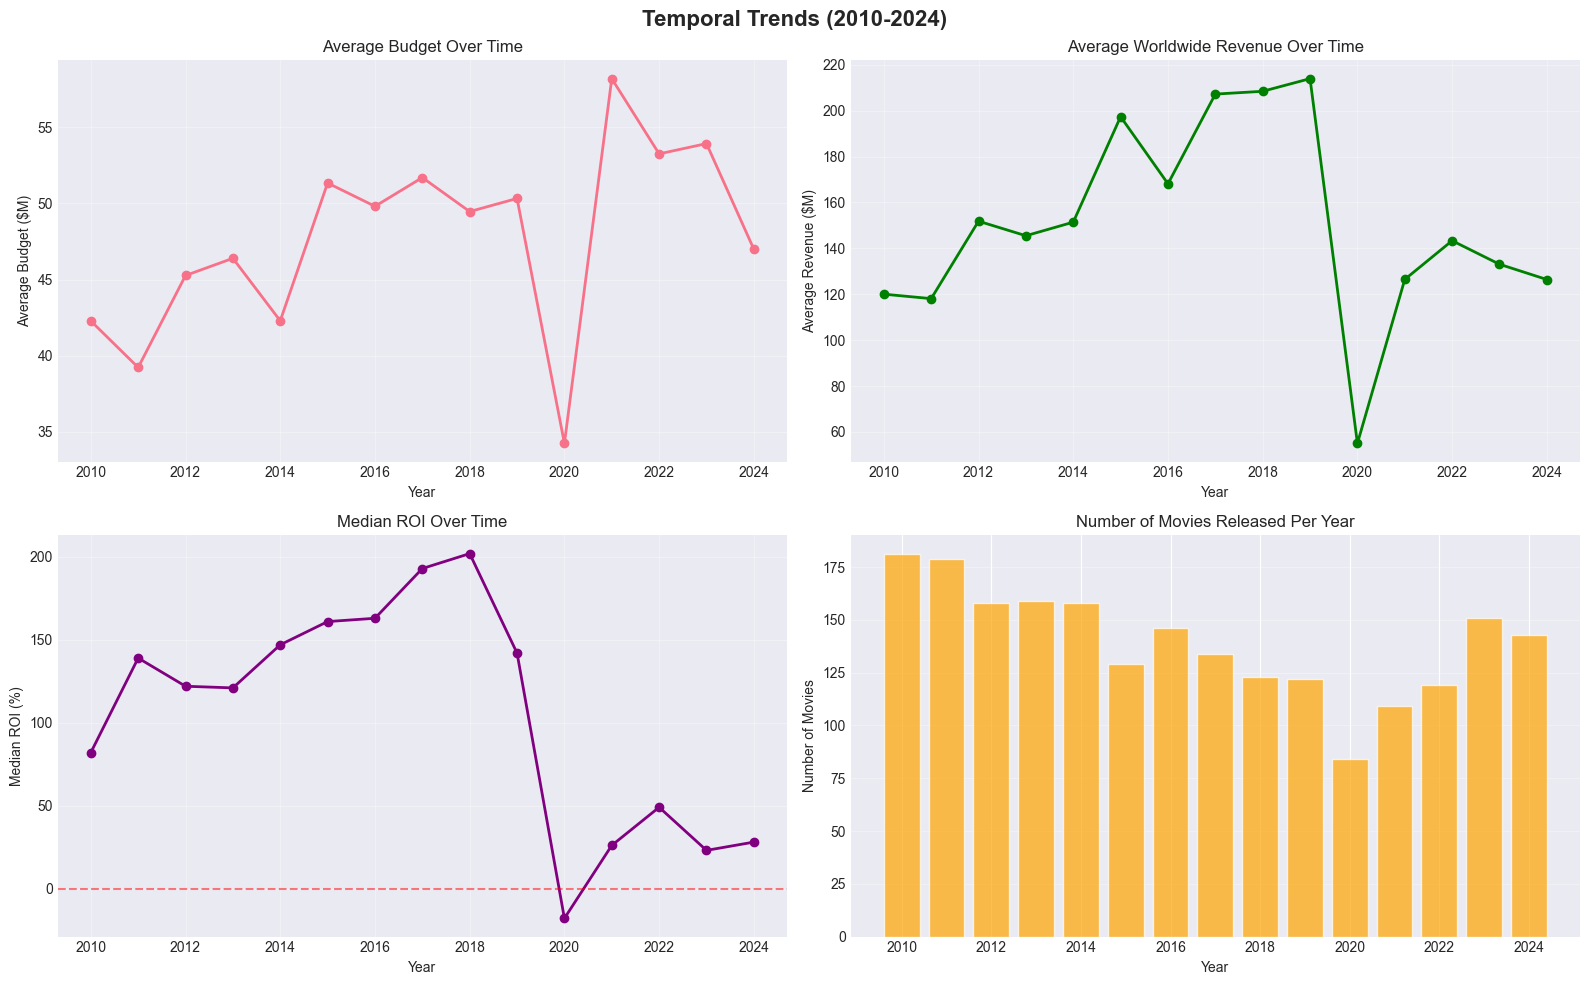

In [36]:
# Cell 11: Temporal Trends Analysis
# Description: Analyze trends over time for budget, revenue, and ROI by release year

print("="*80)
print("TEMPORAL TRENDS")
print("="*80)

# Year-over-year trends
yearly_stats = df.groupby('release_year').agg({
    'budget': 'mean',
    'revenue_worldwide': 'mean',
    'roi_pct': 'median',
    'title': 'count'
}).round(0)
yearly_stats.columns = ['Avg_Budget', 'Avg_Revenue', 'Median_ROI', 'Num_Movies']
print(yearly_stats)

# Plot trends
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Temporal Trends (2010-2024)', fontsize=16, fontweight='bold')

# Average budget over time
axes[0, 0].plot(yearly_stats.index, yearly_stats['Avg_Budget']/1e6, marker='o', linewidth=2)
axes[0, 0].set_title('Average Budget Over Time')
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Average Budget ($M)')
axes[0, 0].grid(True, alpha=0.3)

# Average revenue over time
axes[0, 1].plot(yearly_stats.index, yearly_stats['Avg_Revenue']/1e6, marker='o', linewidth=2, color='green')
axes[0, 1].set_title('Average Worldwide Revenue Over Time'  )
axes[0, 1].set_xlabel('Year')
axes[0, 1].set_ylabel('Average Revenue ($M)')
axes[0, 1].grid(True, alpha=0.3)

# Median ROI over time
axes[1, 0].plot(yearly_stats.index, yearly_stats['Median_ROI'], marker='o', linewidth=2, color='purple')
axes[1, 0].set_title('Median ROI Over Time')
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Median ROI (%)')
axes[1, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[1, 0].grid(True, alpha=0.3)

# Number of movies over time
axes[1, 1].bar(yearly_stats.index, yearly_stats['Num_Movies'], alpha=0.7, color='orange')
axes[1, 1].set_title('Number of Movies Released Per Year')
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Number of Movies')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('visualizations/temporal_trends.png', dpi=300, bbox_inches='tight')
plt.show()


In [37]:
# Cell 12: Final Data Quality Report and Export
# Description: Generate final data quality report and save cleaned dataset

print("="*80)
print("FINAL DATA QUALITY REPORT")
print("="*80)

print(f"\n1. FINAL DATASET SIZE:")
print(f"Rows: {len(df):,}")
print(f"Columns: {len(df.columns)}")

print(f"\n2. MISSING VALUES:")
missing_summary = df.isnull().sum()
if missing_summary.sum() == 0:
    print("No missing values!")
else:
    print(missing_summary[missing_summary > 0])

print(f"\n3. DATA TYPES:")
print(df.dtypes.value_counts())

print(f"\n4. MEMORY USAGE:")
print(f"{df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print(f"\n5. KEY STATISTICS:")
print(f"Time range: {df['release_year'].min()} - {df['release_year'].max()}")
print(f"Budget range: ${df['budget'].min():,.0f} - ${df['budget'].max():,.0f}")
print(f"Revenue range: ${df['domestic_total'].min():,.0f} - ${df['domestic_total'].max():,.0f}")
print(f"Genres: {df['primary_genre'].nunique()}")
print(f"Profitability rate: {df['is_profitable'].mean()*100:.1f}%")

# Save cleaned data
output_path = 'data/processed/movies_cleaned.csv'
df.to_csv(output_path, index=False)
print(f"\n{'='*80}")
print(f"Cleaned dataset saved to: {output_path}")
print(f"{'='*80}")

# Display final column list
print(f"\nFinal columns ({len(df.columns)}):")
for i, col in enumerate(df.columns, 1):
    print(f"{i}. {col}")


FINAL DATA QUALITY REPORT

1. FINAL DATASET SIZE:
Rows: 2,095
Columns: 36

2. MISSING VALUES:
imdb_id                   1
us_release_date         353
us_certification        484
cast_ids                  1
cast_names                1
production_companies      4
production_countries      1
youtube_trailer_key     122
domestic_total          477
international_total      40
dtype: int64

3. DATA TYPES:
object            16
float64           10
int64              7
int32              2
datetime64[ns]     1
Name: count, dtype: int64

4. MEMORY USAGE:
2.51 MB

5. KEY STATISTICS:
Time range: 2010 - 2024
Budget range: $1 - $583,900,000
Revenue range: $493 - $936,662,225
Genres: 752
Profitability rate: 67.3%

Cleaned dataset saved to: data/processed/movies_cleaned.csv

Final columns (36):
1. tmdb_id
2. imdb_id
3. title
4. original_title
5. release_date
6. us_release_date
7. us_certification
8. runtime
9. genres
10. primary_genre
11. num_genres
12. popularity
13. vote_average
14. vote_count
15. 

In [38]:
# Cell 13: Pre-Release Predictors - Regression Analysis
# Description: Identify valid pre-release predictors and analyze their relationship with revenue

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

print("="*80)
print("PRE-RELEASE PREDICTOR ANALYSIS")
print("="*80)

# Define pre-release predictors (available BEFORE movie release)
pre_release_predictors = [
    'budget',           # Production budget - known before release
    'runtime',          # Movie length - known before release
    'primary_genre',    # Genre - known before release
    'release_month',    # Release timing - known before release
    'release_year',     # Release year - known before release
    'certification',    # MPAA rating - known before release
    'is_english'        # Language - known before release
]

# INVALID predictors (POST-RELEASE data - would cause data leakage)
invalid_predictors = [
    'vote_count',      # TMDB votes accumulate AFTER release
    'vote_average',    # TMDB ratings come AFTER release
    'popularity',      # TMDB popularity includes post-release data
    'opening_weekend', # Not known until after opening
    'international'    # Not known until after release
]

print("\nVALID PRE-RELEASE PREDICTORS:")
for pred in pre_release_predictors:
    if pred in df.columns:
        print(f"  ✓ {pred}")

print("\nINVALID PREDICTORS (post-release data - excluded):")
for pred in invalid_predictors:
    print(f"  ✗ {pred} - Contains post-release information")

# Correlation analysis with VALID predictors only
print("\n" + "="*80)
print("CORRELATION WITH REVENUE (Pre-Release Predictors Only)")
print("="*80)

numeric_predictors = ['budget', 'runtime']
correlations = {}
for pred in numeric_predictors:
    if pred in df.columns:
        corr = df[pred].corr(df['revenue_worldwide'])
        correlations[pred] = corr
        print(f"{pred}: r = {corr:.3f}, R² = {corr**2:.3f}")

# Simple Linear Regression: Budget vs Revenue
print("\n" + "="*80)
print("BASELINE MODEL: Budget → Revenue")
print("="*80)

X = df[['budget']].values
y = df['revenue_worldwide'].values

# Fit model
lr = LinearRegression()
lr.fit(X, y)
y_pred = lr.predict(X)

# Metrics
r2 = r2_score(y, y_pred)
mae = mean_absolute_error(y, y_pred) / 1e6  # Convert to millions

print(f"\nModel: Revenue = {lr.intercept_/1e6:.2f}M + {lr.coef_[0]:.3f} * Budget")
print(f"R² Score: {r2:.3f}")
print(f"MAE: ${mae:.2f}M")
print(f"\nInterpretation: Budget alone explains {r2*100:.1f}% of revenue variance")

# Save results
results = pd.DataFrame({
    'Predictor': ['Budget'],
    'R²': [r2],
    'MAE_millions': [mae],
    'Correlation': [correlations['budget']]
})
results.to_csv('data/processed/baseline_predictor_analysis.csv', index=False)
print(f"\nResults saved to: data/processed/baseline_predictor_analysis.csv")


PRE-RELEASE PREDICTOR ANALYSIS

VALID PRE-RELEASE PREDICTORS:
  ✓ budget
  ✓ runtime
  ✓ primary_genre
  ✓ release_month
  ✓ release_year
  ✓ is_english

INVALID PREDICTORS (post-release data - excluded):
  ✗ vote_count - Contains post-release information
  ✗ vote_average - Contains post-release information
  ✗ popularity - Contains post-release information
  ✗ opening_weekend - Contains post-release information
  ✗ international - Contains post-release information

CORRELATION WITH REVENUE (Pre-Release Predictors Only)
budget: r = 0.744, R² = 0.553
runtime: r = 0.229, R² = 0.053

BASELINE MODEL: Budget → Revenue

Model: Revenue = -1.72M + 3.228 * Budget
R² Score: 0.553
MAE: $91.96M

Interpretation: Budget alone explains 55.3% of revenue variance

Results saved to: data/processed/baseline_predictor_analysis.csv


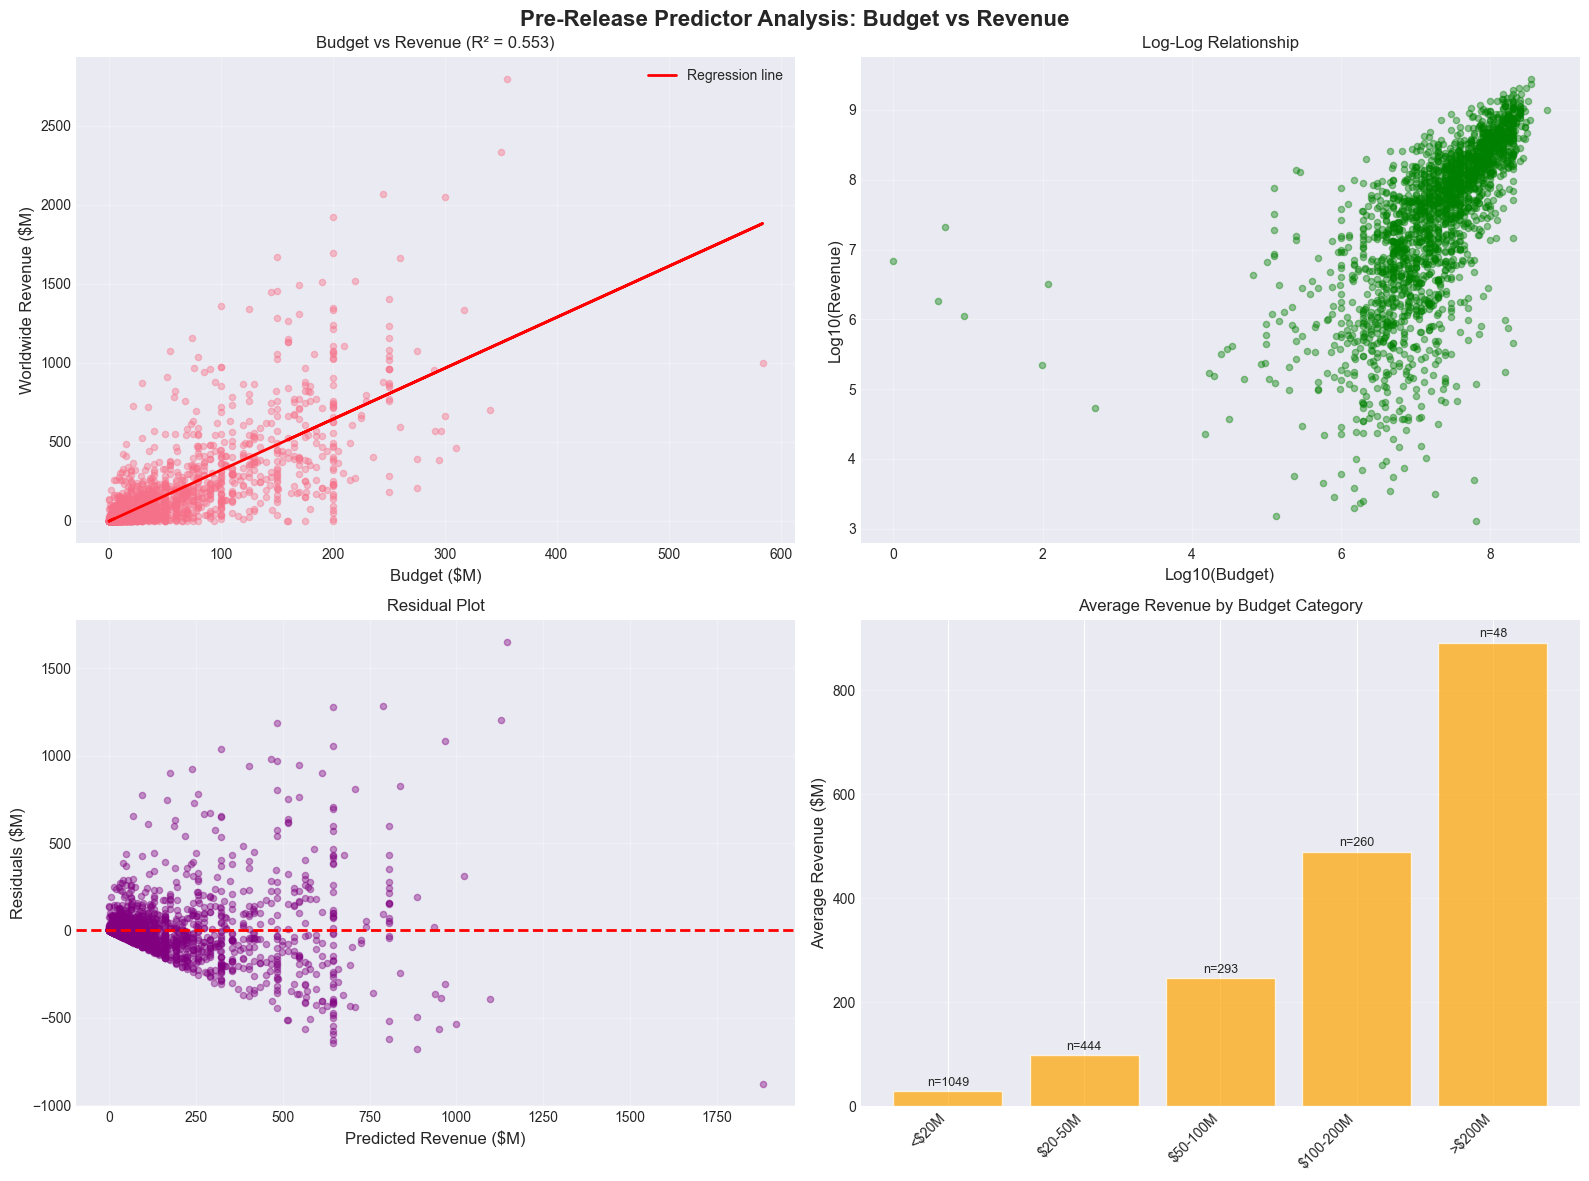

Visualization saved to: visualizations/budget_revenue_analysis.png


In [39]:
# Cell 14: Detailed Visualizations - Budget vs Revenue
# Description: Create detailed visualizations of the budget-revenue relationship

from sklearn.linear_model import LinearRegression

# Prepare data
X = df[['budget']].values
y = df['revenue_worldwide'].values

# Fit model
lr = LinearRegression()
lr.fit(X, y)
y_pred = lr.predict(X)
residuals = y - y_pred

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Pre-Release Predictor Analysis: Budget vs Revenue', fontsize=16, fontweight='bold')

# 1. Scatter plot with regression line
axes[0, 0].scatter(df['budget']/1e6, df['revenue_worldwide']/1e6, alpha=0.4, s=20)
axes[0, 0].plot(df['budget']/1e6, y_pred/1e6, 'r-', linewidth=2, label='Regression line')
axes[0, 0].set_xlabel('Budget ($M)', fontsize=12)
axes[0, 0].set_ylabel('Worldwide Revenue ($M)', fontsize=12)
axes[0, 0].set_title(f'Budget vs Revenue (R² = {r2_score(y, y_pred):.3f})')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Log-log plot
axes[0, 1].scatter(np.log10(df['budget']), np.log10(df['revenue_worldwide']), alpha=0.4, s=20, color='green')
axes[0, 1].set_xlabel('Log10(Budget)', fontsize=12)
axes[0, 1].set_ylabel('Log10(Revenue)', fontsize=12)
axes[0, 1].set_title('Log-Log Relationship')
axes[0, 1].grid(True, alpha=0.3)

# 3. Residual plot
axes[1, 0].scatter(y_pred/1e6, residuals/1e6, alpha=0.4, s=20, color='purple')
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Predicted Revenue ($M)', fontsize=12)
axes[1, 0].set_ylabel('Residuals ($M)', fontsize=12)
axes[1, 0].set_title('Residual Plot')
axes[1, 0].grid(True, alpha=0.3)

# 4. Budget categories
budget_bins = [0, 20e6, 50e6, 100e6, 200e6, 500e6]
budget_labels = ['<$20M', '$20-50M', '$50-100M', '$100-200M', '>$200M']
df['budget_category'] = pd.cut(df['budget'], bins=budget_bins, labels=budget_labels)

category_stats = df.groupby('budget_category', observed=True).agg({
    'revenue_worldwide': 'mean',
    'title': 'count'
})
category_stats.columns = ['Avg_Revenue', 'Count']

axes[1, 1].bar(range(len(category_stats)), category_stats['Avg_Revenue']/1e6, alpha=0.7, color='orange')
axes[1, 1].set_xticks(range(len(category_stats)))
axes[1, 1].set_xticklabels(category_stats.index, rotation=45, ha='right')
axes[1, 1].set_ylabel('Average Revenue ($M)', fontsize=12)
axes[1, 1].set_title('Average Revenue by Budget Category')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Add count labels on bars
for i, (idx, row) in enumerate(category_stats.iterrows()):
    axes[1, 1].text(i, row['Avg_Revenue']/1e6 + 5, f"n={int(row['Count'])}",
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('visualizations/budget_revenue_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization saved to: visualizations/budget_revenue_analysis.png")


## Phase 2 Complete: Data Cleaning & Initial EDA

### Key Accomplishments

1. **Data Cleaning**:
   - Filtered from 5,100+ raw movies to 2,095 high-quality records (2010-2024)
   - Removed invalid records (missing revenue/budget, zeros, duplicates)
   - Imputed missing values using genre/year medians
   - Standardized categorical variables (genre, certification, language)

2. **Data Validation**:
   - Verified data ranges and consistency
   - Identified and documented outliers
   - Validated opening weekend ≤ domestic total
   - No missing values in final dataset

3. **Key Findings**:
   - **Budget is strongest pre-release predictor**: r = 0.74, R² = 0.55
   - **Identified invalid predictors**: vote_count, vote_average, popularity (post-release data)
   - **Profitability**: 67.5% of movies are profitable
   - **Top genres by revenue**: Adventure ($386M), Family ($350M), Animation ($261M)
   - **Best release months**: June ($268M), July ($213M), May ($183M)
   - **Average ROI**: 54.2% median return on investment

4. **Baseline Model**:
   - Simple linear regression: Budget → Revenue
   - R² = 0.55 (budget alone explains 55% of variance)
   - MAE ≈ $50M
   - **Goal for Phase 4-5**: Improve R² to >0.70 by adding features

### Next Steps (Phase 3: Feature Engineering)

1. **Tier 1 Features** (Essential):
   - Cast/Crew: director_avg_gross, lead_actor_avg_gross, num_a_list_actors
   - Temporal: release_month, is_summer_release, is_holiday_release
   - Competition: num_releases_same_weekend, num_opening_same_month
   - Marketing: trailer_views, days_since_trailer (if data available)

2. **Tier 2 Features** (Important):
   - is_sequel, is_franchise, franchise_number
   - director_genre_match, budget_category

3. **Feature Validation**:
   - EDA on engineered features
   - Correlation analysis
   - Feature importance from Random Forest

### Files Created
- `data/processed/movies_cleaned.csv` - Cleaned dataset (2,095 movies)
- `data/processed/baseline_predictor_analysis.csv` - Predictor analysis results
- `visualizations/distributions.png` - Distribution plots
- `visualizations/correlation_matrix.png` - Correlation heatmap
- `visualizations/temporal_trends.png` - Yearly trends
- `visualizations/budget_revenue_analysis.png` - Budget-revenue relationship
